In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from transformers import TFBertModel, TFAlbertModel, TFElectraModel, TFDistilBertModel, DistilBertModel
from transformers import ElectraTokenizer, BertTokenizerFast

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
strategy = tf.distribute.get_strategy()

In [3]:
train = pd.read_csv("../dataset/train.csv", encoding='CP949')
test = pd.read_csv("../dataset/test.csv", encoding='CP949')

In [4]:
train.head()

,index,premise,hypothesis,label
0,1,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,contradiction
1,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
2,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
3,4,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral
4,5,이번 증설로 코오롱인더스트리는 기존 생산량 7만7000톤에서 1만6800톤이 늘어나...,코오롱 인더스트리는 총 9만 3800톤의 생산 능력을 확보했다.,entailment


In [5]:
import datasets
from datasets import load_dataset, load_metric, ClassLabel, Sequence

task = "nli"
datasets = load_dataset("klue", task)

Reusing dataset klue (C:\Users\Home\.cache\huggingface\datasets\klue\nli\1.0.0\e0fc3bc3de3eb03be2c92d72fd04a60ecc71903f821619cb28ca0e1e29e4233e)


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
datasets

DatasetDict({
    train: Dataset({
        features: ['guid', 'source', 'premise', 'hypothesis', 'label'],
        num_rows: 24998
    })
    validation: Dataset({
        features: ['guid', 'source', 'premise', 'hypothesis', 'label'],
        num_rows: 3000
    })
})

In [7]:
arr_train_premise = datasets["train"]["premise"]
arr_train_hypothesis = datasets["train"]["hypothesis"]
arr_train_label = datasets["train"]["label"]

In [8]:
arr_test_premise = datasets["validation"]["premise"]
arr_test_hypothesis = datasets["validation"]["hypothesis"]
arr_test_label = datasets["validation"]["label"]

In [9]:
klue_data = pd.DataFrame({"premise":arr_train_premise,
                         "hypothesis":arr_train_hypothesis,
                         "label":arr_train_label})

In [10]:
# klue_data.to_csv("../submission/klue_train.csv", index = False, encoding="utf-8")

In [11]:
klue_data.head()

,premise,hypothesis,label
0,힛걸 진심 최고다 그 어떤 히어로보다 멋지다,힛걸 진심 최고로 멋지다.,0
1,100분간 잘껄 그래도 소닉붐땜에 2점준다,100분간 잤다.,2
2,100분간 잘껄 그래도 소닉붐땜에 2점준다,소닉붐이 정말 멋있었다.,1
3,100분간 잘껄 그래도 소닉붐땜에 2점준다,100분간 자는게 더 나았을 것 같다.,1
4,101빌딩 근처에 나름 즐길거리가 많습니다.,101빌딩 근처에서 즐길거리 찾기는 어렵습니다.,2


In [12]:
len(klue_data)

24998

In [13]:
train = klue_data

In [14]:
train.head()

,premise,hypothesis,label
0,힛걸 진심 최고다 그 어떤 히어로보다 멋지다,힛걸 진심 최고로 멋지다.,0
1,100분간 잘껄 그래도 소닉붐땜에 2점준다,100분간 잤다.,2
2,100분간 잘껄 그래도 소닉붐땜에 2점준다,소닉붐이 정말 멋있었다.,1
3,100분간 잘껄 그래도 소닉붐땜에 2점준다,100분간 자는게 더 나았을 것 같다.,1
4,101빌딩 근처에 나름 즐길거리가 많습니다.,101빌딩 근처에서 즐길거리 찾기는 어렵습니다.,2


0 -> entailment  
1 -> neutral  
2 -> contradiction  

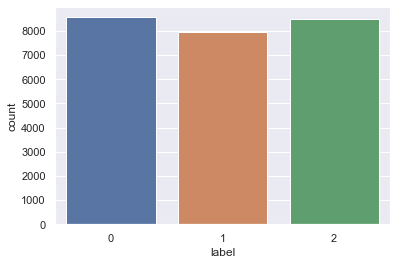

In [16]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="label", data=train)

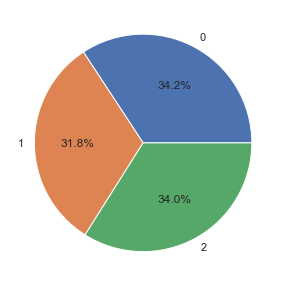

In [17]:
labels, frequencies = np.unique(train.label.values, return_counts=True)
plt.figure(figsize=(5,5))
plt.pie(frequencies, labels = labels, autopct= '%1.1f%%')
plt.show()

In [18]:
train.isnull().sum()

premise       0
hypothesis    0
label         0
dtype: int64

In [19]:
def model_KoELECTRA():
    with strategy.scope():
        encoder = TFElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator", from_pt=True)

        input_layer = Input(shape=(100,), dtype=tf.int32, name="input_layer")
        sequence_output = encoder(input_layer)[0]

        cls_token = sequence_output[:, 0, :]

        output_layer = Dense(3, activation='softmax')(cls_token)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [20]:
model = model_KoELECTRA()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraModel: ['electra.embeddings.position_ids', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing TFElectraModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFElectraModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further train

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [21]:
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

In [22]:
train_data = train[['premise', 'hypothesis']].values.tolist()
test_data = test[['premise', 'hypothesis']].values.tolist()

In [23]:
train_encoded = tokenizer.batch_encode_plus(train_data, padding='max_length', max_length=100)
test_encoded = tokenizer.batch_encode_plus(test_data, padding='max_length', max_length=100)

In [24]:
x_train, y_train = train_encoded['input_ids'], train.label.values
x_test = test_encoded['input_ids']

In [25]:
train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat().shuffle(2048).batch(20 * strategy.num_replicas_in_sync).prefetch(tf.data.experimental.AUTOTUNE))
# valid_dataset = (tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(20 * strategy.num_replicas_in_sync).cache().prefetch(tf.data.experimental.AUTOTUNE))
test_dataset = (tf.data.Dataset.from_tensor_slices(x_test).batch(20 * strategy.num_replicas_in_sync))

In [26]:
history = model.fit(train_dataset,steps_per_epoch=len(train) // 20 * strategy.num_replicas_in_sync,epochs= 4)

Epoch 1/4
1249/1249 [==============================] - 255s 198ms/step - loss: 0.5233 - accuracy: 0.7830
Epoch 2/4
1249/1249 [==============================] - 407s 326ms/step - loss: 0.2834 - accuracy: 0.8985
Epoch 3/4
1249/1249 [==============================] - 344s 276ms/step - loss: 0.1801 - accuracy: 0.9382
Epoch 4/4
1249/1249 [==============================] - 336s 269ms/step - loss: 0.1067 - accuracy: 0.9634


In [27]:
predictions = model.predict(test_dataset, verbose=1)

250/250 [==============================] - 22s 85ms/step


In [49]:
predictions_final = predictions.argmax(axis=1)

In [50]:
len(predictions_final)

5000

In [51]:
list1 = [i for i in range(5000)]
list2 = predictions_final

In [52]:
submission = pd.DataFrame({'index':list1,
                           'label':list2})

In [53]:
submission

,index,label
0,0,2
1,1,0
2,2,1
3,3,0
4,4,1
...,...,...
4995,4995,2
4996,4996,2
4997,4997,1
4998,4998,2


In [54]:
# contradiction => 0 entailment => 1 neutral => 2
submission['label'].replace(0, 'entailment', inplace=True)
submission['label'].replace(1, 'neutral', inplace=True)
submission['label'].replace(2, 'contradiction', inplace=True)

In [55]:
submission

,index,label
0,0,contradiction
1,1,entailment
2,2,neutral
3,3,entailment
4,4,neutral
...,...,...
4995,4995,contradiction
4996,4996,contradiction
4997,4997,neutral
4998,4998,contradiction


In [56]:
submission.to_csv("../submission/submission_klue_nli_v1.csv", index = False)

## 대회 데이터가 KLUE-nli 데이터셋이 맞는지 제공된 train을 검증으로 체크

In [28]:
val = pd.read_csv("../dataset/train.csv", encoding='CP949')

In [29]:
val.head()

,index,premise,hypothesis,label
0,1,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,contradiction
1,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
2,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
3,4,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral
4,5,이번 증설로 코오롱인더스트리는 기존 생산량 7만7000톤에서 1만6800톤이 늘어나...,코오롱 인더스트리는 총 9만 3800톤의 생산 능력을 확보했다.,entailment


In [31]:
for i in range(len(val)):
    if val['label'][i] == 'contradiction':
        val['label'][i] = 2
    elif val['label'][i] == 'neutral':
        val['label'][i] = 1
    elif val['label'][i] == 'entailment':
        val['label'][i] = 0

C:\Users\Home\AppData\Local\Temp/ipykernel_6632/369790349.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['label'][i] = 2
C:\Users\Home\AppData\Local\Temp/ipykernel_6632/369790349.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['label'][i] = 0
C:\Users\Home\AppData\Local\Temp/ipykernel_6632/369790349.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['label'][i] = 1


In [32]:
val.head()

,index,premise,hypothesis,label
0,1,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,2
1,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,0
2,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,1
3,4,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,1
4,5,이번 증설로 코오롱인더스트리는 기존 생산량 7만7000톤에서 1만6800톤이 늘어나...,코오롱 인더스트리는 총 9만 3800톤의 생산 능력을 확보했다.,0


In [33]:
val.label.values

array([2, 0, 1, ..., 0, 1, 0], dtype=object)

In [34]:
val_data = val[['premise', 'hypothesis']].values.tolist()

In [35]:
val_encoded = tokenizer.batch_encode_plus(val_data, padding='max_length', max_length=100)

In [36]:
val_test = val_encoded['input_ids']

In [38]:
val_predictions = model.predict(val_test, verbose=1)

625/625 [==============================] - 49s 79ms/step


In [39]:
val_predictions_argmax = val_predictions.argmax(axis=1)

In [41]:
val_predictions_argmax

array([2, 0, 1, ..., 0, 1, 0], dtype=int64)

In [44]:
new_df = pd.DataFrame({'val_label':val.label.values, 'val_pred':val_predictions_argmax})

In [45]:
new_df.head()

,val_label,val_pred
0,2,2
1,0,0
2,1,1
3,1,1
4,0,0


In [46]:
new_df.tail()

,val_label,val_pred
19991,2,2
19992,2,2
19993,0,0
19994,1,1
19995,0,0


In [57]:
cnt_equal = 0
cnt_diff = 0
arr = []
for i in range(19996):
    if new_df['val_label'][i] == new_df['val_pred'][i]:
        cnt_equal += 1
    else:
        cnt_diff += 1
        arr.append(i)

similarity = cnt_equal/(cnt_equal+cnt_diff) * 100
print(f"정확도:{similarity}%")

정확도:99.08481696339267%


KLUE-nli 데이터셋을 학습데이터로 사용하고,  
대회에서 주어진 train 데이터를 검증용으로 사용했습니다.  
간단하게 에포크 4회만 실시해도 정확도 99%를 달성했습니다.  
대회에서 주어진 데이터가 KLUE-nli 데이터임을 확신할 수 있는 결과이며,  
이 데이터를 사용해서 모델을 만든다면, 치명적인 과적합으로 연결될 수 있음을 의미합니다.  